In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector


In [81]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
contours_lines_table_name='contours_lines'
tree_edges_table_name="tree_edges"
osm_nodes_table_name="osm_nodes"
osm_intersections_table_name="osm_intersections"
2

2

In [3]:
t1=time.time()
G=build_graph(cursor)
t2=time.time()
print(t2-t1)

0.6776649951934814


In [4]:
t1=time.time()
cmd="SELECT osm_id,contour_line_id,ST_asText(geometry) AS geometry FROM %s WHERE contour_line_id IS NOT NULL"%osm_nodes_table_name
cursor.execute(cmd)
nodes_data=pd.DataFrame(cursor.fetchall())
nodes_data['geometry']=nodes_data['geometry'].apply(lambda pt:loads(pt))
nodes_data=nodes_data.set_index('osm_id',drop=False)
nodes_data=gpd.GeoDataFrame(nodes_data,geometry='geometry',crs='epsg:4326')
nodes_data['old_geometry']=nodes_data['geometry'].copy()
crs=nodes_data.estimate_utm_crs()
nodes_data=nodes_data.to_crs(crs)
nodes_data['depth']=nodes_data['contour_line_id'].apply(lambda contour_line_id:G.nodes()[contour_line_id]['depth'])
t2=time.time()
print(t2-t1)

1.3779196739196777


In [5]:
contour_line_ids=nodes_data[nodes_data.depth>400]['contour_line_id'].unique()
contour_line_ids=[contour_line_id for contour_line_id in contour_line_ids if len(list(G.neighbors(contour_line_id)))>1]
contour_line_ids

[21765,
 115880,
 54878,
 4643,
 4538,
 5305,
 115887,
 51572,
 115988,
 24110,
 116089,
 56085,
 54393,
 1380,
 51038,
 13742,
 115908,
 8474,
 115873,
 115882,
 11416,
 54588,
 53737,
 115891]

In [6]:
54878,53737,24110

(54878, 53737)

In [19]:
root_contour_line_id

24110

In [162]:
root_contour_line_id=random.choice(contour_line_ids)
root_contour_line_id=53737
neighbor_contour_line_ids=list(G.neighbors(root_contour_line_id))
local_contours_line_ids=[root_contour_line_id]+neighbor_contour_line_ids
local_contour_data=get_nodes_data(cursor,local_contours_line_ids)
local_contour_data=local_contour_data.to_crs(crs)
local_contour_data=local_contour_data.set_index('id')
local_nodes_data=nodes_data[nodes_data.contour_line_id==root_contour_line_id].copy()

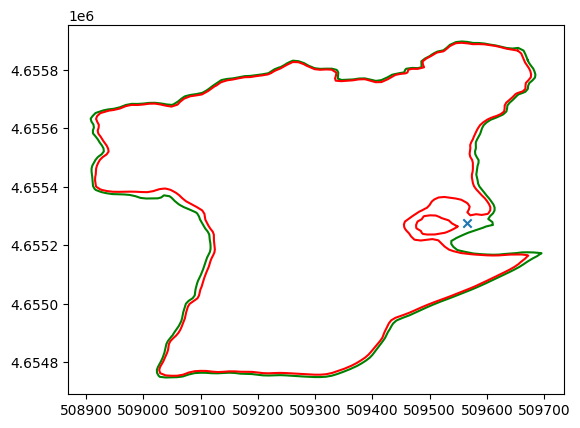

In [163]:
for contour_line_id,row in local_contour_data.iterrows():
    ls=row['geometry']
    coords=np.array(ls.coords)
    if contour_line_id==root_contour_line_id:
        plt.plot(coords[:,0],coords[:,1],c='g')
        for pt in local_nodes_data['geometry']:
            assert pt.within(Polygon(ls))
            plt.scatter(pt.x,pt.y,marker='x')
    else:
        plt.plot(coords[:,0],coords[:,1],c='r')


In [173]:
def select_affine_basis_for_point(osm_pt,local_contour_data):
    elevations=np.array(local_contour_data['elevation'])
    projected_pts=[ls.interpolate(ls.project(osm_pt)) for ls in list(local_contour_data['geometry'])]
    if len(local_contour_data)<3:
        return list(zip(projected_pts,elevations))
    else:
        distances=[osm_pt.distance(projected_pt) for projected_pt in projected_pts]
        argsort=np.argsort(distances)
        return [(projected_pts[i],elevations[i]) for i in argsort[:3]]

def select_affine_basis_for_data_frame(local_nodes_data,local_contour_data):
    L=list(zip(*local_nodes_data['geometry'].apply(lambda osm_pt:select_affine_basis_for_point(osm_pt,local_contour_data))))
    for i,l in enumerate(L):
        pts,elev=zip(*l)
        local_nodes_data['point_%i'%i]=pts
        local_nodes_data['elevation_%i'%i]=elev
    return local_nodes_data


In [174]:
t1=time.time()
local_nodes_data=select_affine_basis_for_data_frame(local_nodes_data,local_contour_data)
t2=time.time()
print(t2-t1)

KeyboardInterrupt: 

In [ ]:
local_nodes_data

In [167]:
osm_pt=local_nodes_data.iloc[0]['geometry']
projected_pts=[ls.interpolate(ls.project(osm_pt)) for ls in list(local_contour_data['geometry'])]
distances=[osm_pt.distance(projected_pt) for projected_pt in projected_pts]


In [168]:
distances

[30.500527995557693, 20.98458216952279, 25.401702950708085]

In [ ]:
k_max=10
cols=[]
max_nb_neighbors=1000
for k in range(k_max):
    nodes_data['point_%i'%k]=None
    cols.append('point_%i'%k)
    nodes_data['elevation_%i'%k]=None
    cols.append('elevation_%i'%k)
    nodes_data['distance_%i'%k]=None
    cols.append('distance_%i'%k)
    
t1=time.time()
contour_line_ids=nodes_data['contour_line_id'].unique()
contour_lines_ids=sorted(contour_line_ids,key=lambda contour_line_id:len(list(G.neighbors(contour_line_id))))
contour_lines_ids=contour_lines_ids[::-1]
print('sorted')
for k,root_contour_line_id in enumerate(contour_lines_ids):
    if (k+1)%10==0:
        print('%i/%i'%(k+1,len(contour_line_ids)))
    neighbor_contour_line_ids=list(G.neighbors(root_contour_line_id))
    print('%i neighbors'%len(neighbor_contour_line_ids))
    if len(neighbor_contour_line_ids)<max_nb_neighbors:
        t3=time.time()
        local_contours_line_ids=[root_contour_line_id]+neighbor_contour_line_ids
        local_contour_data=get_nodes_data(cursor,local_contours_line_ids)
        local_contour_data=local_contour_data.to_crs(crs)
        local_contour_data=local_contour_data.set_index('id')
        t4=time.time()
        print('setting up df took %f'%(t4-t3))
        local_nodes_data=nodes_data[nodes_data.contour_line_id==root_contour_line_id].copy()
        local_nodes_data=select_affine_basis_for_data_frame(local_nodes_data,local_contour_data,k_max=k_max)
        nodes_data.loc[nodes_data.contour_line_id==root_contour_line_id,cols]=local_nodes_data.loc[:,cols]
    
        t5=time.time()
        print('finding affine basis took %f'%(t5-t4))
        print('intermediate time %f'%(t5-t1))
t2=time.time()
print(t2-t1)

sorted
607 neighbors
setting up df took 0.687290


/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [ ]:
for _,row in nodes_data.iterrows():
    distances=[row['distance_%i'%k] for k in range(k_max)]
    print(distances)
    distances=[distance for distance in distances if distance is not None]    
    assert np.all(np.diff(distances)>=0)
